In [1]:
from pathlib import Path

import pandas as pd

from auction.inputs import ModelInputs
from auction.splitter import RandomSplitter
from auction.model import CatModel, BaseModel
from auction.constants import TARGET_COL, UNIQ_COL
from auction.utils import parse_train_report

pd.options.display.max_columns = 100
pd.options.display.max_rows = 190

In [2]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
train.shape[0], test.shape[0]

(9640735, 1500000)

[2024-09-30 23:06:59][INFO] Train data shape is (8060895, 17)
[2024-09-30 23:07:03][INFO] Test data shape is (1579840, 17)
[2024-09-30 23:07:17][WARNING]  Test uniq targets: 2; Train uniq targets: 2;


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6083007	test: 0.6246356	best: 0.6246356 (0)	total: 511ms	remaining: 1m 41s
15:	learn: 0.2108863	test: 0.3049506	best: 0.3049506 (15)	total: 8.58s	remaining: 1m 38s
30:	learn: 0.1644954	test: 0.2596399	best: 0.2596399 (30)	total: 17.2s	remaining: 1m 33s
45:	learn: 0.1531174	test: 0.2478693	best: 0.2478693 (45)	total: 25.5s	remaining: 1m 25s
60:	learn: 0.1482925	test: 0.2421308	best: 0.2421308 (60)	total: 33.9s	remaining: 1m 17s
75:	learn: 0.1456125	test: 0.2389378	best: 0.2389378 (75)	total: 42.3s	remaining: 1m 9s
90:	learn: 0.1438156	test: 0.2366682	best: 0.2366682 (90)	total: 50.7s	remaining: 1m
105:	learn: 0.1424298	test: 0.2348000	best: 0.2348000 (105)	total: 59.2s	remaining: 52.5s
120:	learn: 0.1415109	test: 0.2335277	best: 0.2335277 (120)	total: 1m 7s	remaining: 44.2s
135:	learn: 0.1407891	test: 0.2324112	best: 0.2324112 (135)	total: 1m 15s	remaining: 35.7s
150:	learn: 0.1401707	test: 0.2314926	best: 0.2314926 (150)	total: 1m 24s	remaining: 27.5s
165:	learn: 0.1396695	

,iteration,Train_Logloss,Test_Logloss,Train_F1,Test_F1,Train_AUC,Test_AUC
0,0,0.608301,0.624636,0.521345,0.561915,0.895311,0.876510
1,15,0.210886,0.304951,0.376562,0.412978,0.918705,0.899972
2,30,0.164495,0.259640,0.449939,0.489870,0.927584,0.906196
3,45,0.153117,0.247869,0.483706,0.525083,0.930517,0.908892
4,60,0.148292,0.242131,0.499483,0.541329,0.933186,0.912065
5,75,0.145612,0.238938,0.508722,0.550665,0.934817,0.913751
6,90,0.143816,0.236668,0.515399,0.557263,0.936213,0.915111
7,105,0.142430,0.234800,0.523007,0.564772,0.937572,0.916523
8,120,0.141511,0.233528,0.525993,0.567579,0.938526,0.917441
9,135,0.140789,0.232411,0.531770,0.573043,0.939205,0.918164


[2024-09-30 23:10:58][INFO] F1:  Train: 0.5520493708618327; Test: 0.5939992845371354
[2024-09-30 23:10:58][INFO] AUC: Train: 0.8291925765598319; Test: 0.7832955234482789


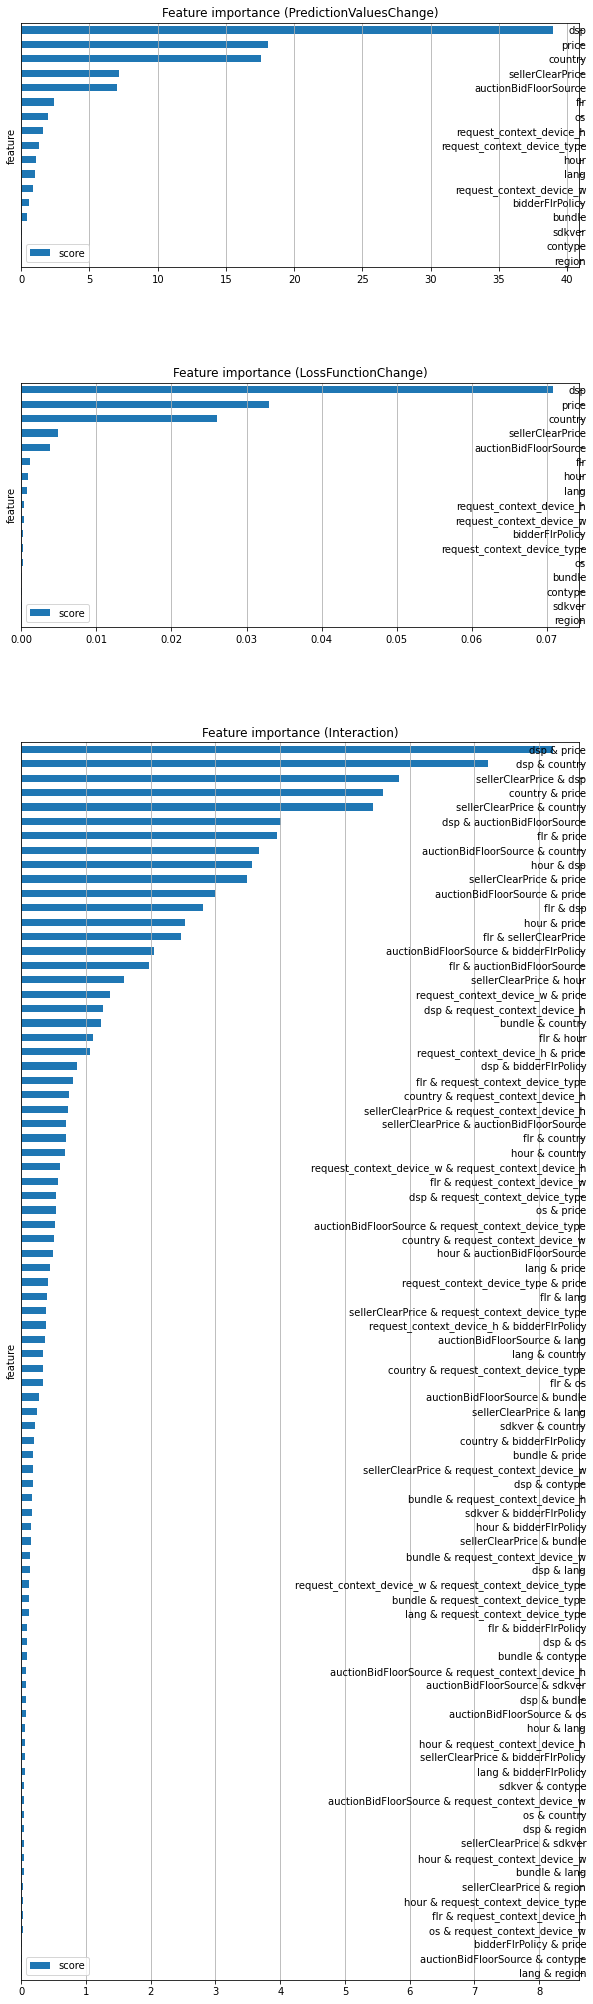

In [4]:
exp_tag = 'baseline_without_const_feats_ifa_sampling'

train_dir = Path(f'./model_logs/{exp_tag}')
train_dir.mkdir(parents=True, exist_ok=True)

# I have removed features with one and only unique feature value across train and test data
features_to_skip = [
    'ssp', 'sdk', 'adt', 'dc',
    TARGET_COL, UNIQ_COL,
]

feature_cols = [x for x in train.columns if x not in features_to_skip]

cat_cols = [
 #'ssp', The one and only value
 'dsp',
 'auctionBidFloorSource',
 #'sdk', The one and only value
 'sdkver',
 'bundle',
 'os',
 'lang',
 'country',
 'region',
 'bidderFlrPolicy',
 #'adt', The one and only value
 #'dc', The one and only value
 'contype',
 'request_context_device_type',
]

# We use only train data for the next experimentations
inputs = ModelInputs(data=train, features_cols=feature_cols, cat_features=cat_cols)

# Split Train dataset randomly for model evaluation (70% goes to train 30% goes to validation);
# We sample data by IFA; One unique value goes only to one sample type (train/test)
params =  {
    "train_test_ratio": 0.70,
    "seed": 1,
    "uniq_col": "ifa"
}

splitter = RandomSplitter(params=params)
inputs.make_test_train(splitter)

# Create CatBoost model classifier
params = {
    "train_dir": str(train_dir),
    "loss_function": "Logloss",
    "iterations": 200,
    "custom_metric": [
      "F1:hints=skip_train~false", "AUC:hints=skip_train~false", 
    ],
    "random_seed": 0,
    "metric_period": 15,
    "depth": 4,
    "task_type": "GPU", # Drop this two lines if you use CPU
    "devices": "1",
    "learning_rate": 0.05
}

model = CatModel(params)

# Fit model
model.fit(inputs)
# Plot importances on validation set
model.plot_feature_importance(inputs)

# Print training progress (train and validation sample metrics)
display(parse_train_report(exp_tag))

# Compute validation metrics on Train data and Submission (Test dataset)
na_value = -99999
model.evaluate_model(train.fillna(na_value), test.fillna(na_value))

# Results of Iter #1
- I don't like this Train/Valid metrics gap. Looks like overfitting.

## Lets change the sampling unit from ifa to dsp (There is no missing values of dsp)

[2024-09-30 23:11:26][INFO] Train data shape is (7721956, 16)
[2024-09-30 23:11:27][INFO] Test data shape is (1918779, 16)
[2024-09-30 23:11:40][WARNING]  Test uniq targets: 2; Train uniq targets: 2;


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5984622	test: 0.6684105	best: 0.6684105 (0)	total: 452ms	remaining: 1m 29s
15:	learn: 0.1534597	test: 0.6209949	best: 0.6209949 (15)	total: 7.18s	remaining: 1m 22s
30:	learn: 0.1069622	test: 0.7202001	best: 0.6209949 (15)	total: 14.6s	remaining: 1m 19s
45:	learn: 0.0958445	test: 0.7557475	best: 0.6209949 (15)	total: 22.4s	remaining: 1m 14s
60:	learn: 0.0919732	test: 0.7589449	best: 0.6209949 (15)	total: 30s	remaining: 1m 8s
75:	learn: 0.0900356	test: 0.7524990	best: 0.6209949 (15)	total: 37.6s	remaining: 1m 1s
90:	learn: 0.0886529	test: 0.7456681	best: 0.6209949 (15)	total: 45s	remaining: 53.9s
105:	learn: 0.0877982	test: 0.7376659	best: 0.6209949 (15)	total: 52.7s	remaining: 46.7s
120:	learn: 0.0871109	test: 0.7342583	best: 0.6209949 (15)	total: 1m	remaining: 39.5s
135:	learn: 0.0865659	test: 0.7312622	best: 0.6209949 (15)	total: 1m 7s	remaining: 31.9s
150:	learn: 0.0861394	test: 0.7291530	best: 0.6209949 (15)	total: 1m 15s	remaining: 24.4s
165:	learn: 0.0857880	test: 0.72

,iteration,Train_Logloss,Test_Logloss,Train_F1,Test_F1,Train_AUC,Test_AUC
0,0,0.598462,0.668411,0.000000,0.000000,0.772848,0.619553
1,15,0.153460,0.620995,0.000081,0.000138,0.854191,0.666452
2,30,0.106962,0.720200,0.038616,0.009662,0.881446,0.699342
3,45,0.095845,0.755748,0.092183,0.020818,0.890665,0.727313
4,60,0.091973,0.758945,0.142897,0.056154,0.895457,0.736020
5,75,0.090036,0.752499,0.189417,0.098857,0.898508,0.744127
6,90,0.088653,0.745668,0.219342,0.134997,0.902229,0.753726
7,105,0.087798,0.737666,0.240597,0.162034,0.904818,0.758363
8,120,0.087111,0.734258,0.251808,0.172069,0.906788,0.763943
9,135,0.086566,0.731262,0.259240,0.180644,0.908573,0.766025


[2024-09-30 23:14:38][INFO] F1:  Train: 0.00012217516677533608; Test: 0.00021082591050440098
[2024-09-30 23:14:38][INFO] AUC: Train: 0.8296168750730825; Test: 0.803094384906415


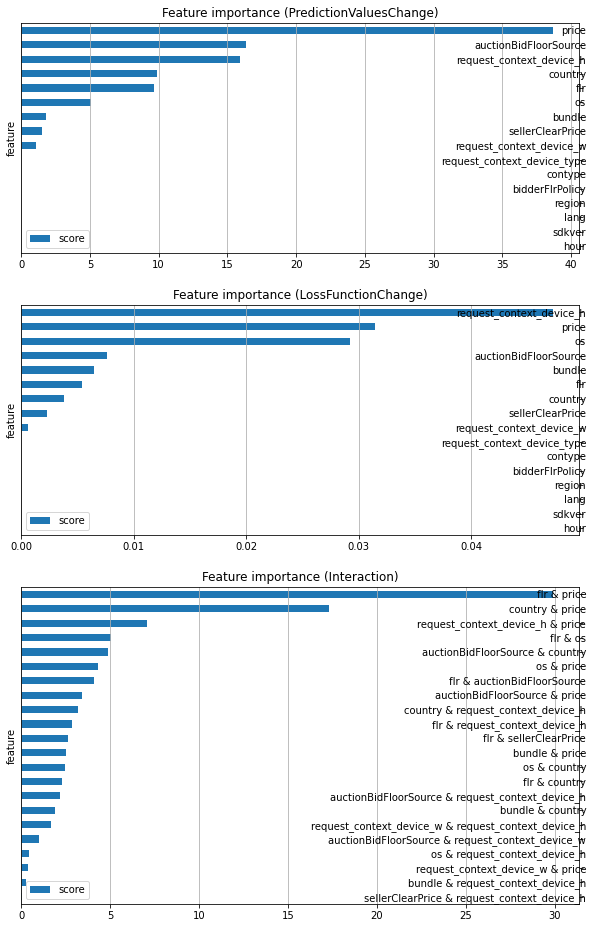

In [5]:
exp_tag = 'baseline_without_const_feats_dsp_sampling'

train_dir = Path(f'./model_logs/{exp_tag}')
train_dir.mkdir(parents=True, exist_ok=True)

# I have removed features with one and only unique feature value across train and test data
features_to_skip = [
    'ssp', 'sdk', 'adt', 'dc',
    'dsp',
    TARGET_COL, UNIQ_COL,
]

feature_cols = [x for x in train.columns if x not in features_to_skip]

cat_cols = [
 #'ssp', The one and only value
 #'dsp',
 'auctionBidFloorSource',
 #'sdk', The one and only value
 'sdkver',
 'bundle',
 'os',
 'lang',
 'country',
 'region',
 'bidderFlrPolicy',
 #'adt', The one and only value
 #'dc', The one and only value
 'contype',
 'request_context_device_type',
]

# We use only train data for the next experimentations
inputs = ModelInputs(
    data=train, features_cols=feature_cols,
    cat_features=cat_cols,
    uniq_col='dsp'
)

# Split Train dataset randomly for model evaluation (70% goes to train 30% goes to validation);
# We sample data by DSP; One unique value goes only to one sample type (train/test)
params =  {
    "train_test_ratio": 0.70,
    "seed": 1,
    "uniq_col": "dsp"
}

splitter = RandomSplitter(params=params)
inputs.make_test_train(splitter)

# Create CatBoost model classifier
params = {
    "train_dir": str(train_dir),
    "loss_function": "Logloss",
    "iterations": 200,
    "custom_metric": [
      "F1:hints=skip_train~false", "AUC:hints=skip_train~false", 
    ],
    "random_seed": 0,
    "metric_period": 15,
    "depth": 4,
    "task_type": "GPU",
    "devices": "1",
    "learning_rate": 0.05
}

model = CatModel(params)

# Fit model
model.fit(inputs)
# Plot importances on validation set
model.plot_feature_importance(inputs)

# Print training progress (train and validation sample metrics)
display(parse_train_report(exp_tag))

# Compute validation metrics on Train data and Submission (Test dataset)
na_value = -99999
model.evaluate_model(train.fillna(na_value), test.fillna(na_value))

# Results of Iter #2
- We have an overfitting. Lets go back to the `ifa` sampling unit

## Let's add fake ids to the impressions without ifa user identifier.

In [6]:
def add_uniq_index_for_missing_values(train_df, col_name):
    """
    Add fake ids to the col_name into the train data
    """
    train_na_idx = train_df.loc[:, col_name].isna()
    
    train_na_count = train_na_idx.sum()    
    train_df.loc[train_na_idx, col_name] = [f'fake_id_{x}' for x in range(train_na_count)]

    return train_df

[2024-09-30 23:15:26][INFO] Train data shape is (6754728, 17)
[2024-09-30 23:15:31][INFO] Test data shape is (2886007, 17)
[2024-09-30 23:15:45][WARNING]  Test uniq targets: 2; Train uniq targets: 2;


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6119087	test: 0.6119384	best: 0.6119384 (0)	total: 435ms	remaining: 1m 26s
15:	learn: 0.2287507	test: 0.2289467	best: 0.2289467 (15)	total: 7.58s	remaining: 1m 27s
30:	learn: 0.1808662	test: 0.1813203	best: 0.1813203 (30)	total: 15s	remaining: 1m 21s
45:	learn: 0.1694241	test: 0.1700255	best: 0.1700255 (45)	total: 22.3s	remaining: 1m 14s
60:	learn: 0.1642673	test: 0.1649034	best: 0.1649034 (60)	total: 29s	remaining: 1m 6s
75:	learn: 0.1610619	test: 0.1617344	best: 0.1617344 (75)	total: 36s	remaining: 58.7s
90:	learn: 0.1592027	test: 0.1598822	best: 0.1598822 (90)	total: 43.2s	remaining: 51.8s
105:	learn: 0.1575573	test: 0.1582186	best: 0.1582186 (105)	total: 50.7s	remaining: 44.9s
120:	learn: 0.1563355	test: 0.1569785	best: 0.1569785 (120)	total: 58s	remaining: 37.9s
135:	learn: 0.1554969	test: 0.1561441	best: 0.1561441 (135)	total: 1m 5s	remaining: 30.6s
150:	learn: 0.1547921	test: 0.1554450	best: 0.1554450 (150)	total: 1m 12s	remaining: 23.5s
165:	learn: 0.1541911	test: 0

,iteration,Train_Logloss,Test_Logloss,Train_F1,Test_F1,Train_AUC,Test_AUC
0,0,0.611909,0.611938,0.535741,0.531415,0.894546,0.893612
1,15,0.228751,0.228947,0.415482,0.410757,0.917877,0.916921
2,30,0.180866,0.181320,0.465231,0.461090,0.924339,0.923426
3,45,0.169424,0.170026,0.493426,0.488971,0.927885,0.926921
4,60,0.164267,0.164903,0.509566,0.505595,0.930214,0.929338
5,75,0.161062,0.161734,0.520202,0.516140,0.932318,0.931460
6,90,0.159203,0.159882,0.529809,0.525774,0.933771,0.932938
7,105,0.157557,0.158219,0.537827,0.533969,0.935185,0.934398
8,120,0.156336,0.156978,0.542738,0.538707,0.936352,0.935638
9,135,0.155497,0.156144,0.547667,0.543680,0.937052,0.936326


[2024-09-30 23:19:20][INFO] F1:  Train: 0.5548105852408056; Test: 0.5831196906691904
[2024-09-30 23:19:20][INFO] AUC: Train: 0.8292580253388657; Test: 0.7967435272018194


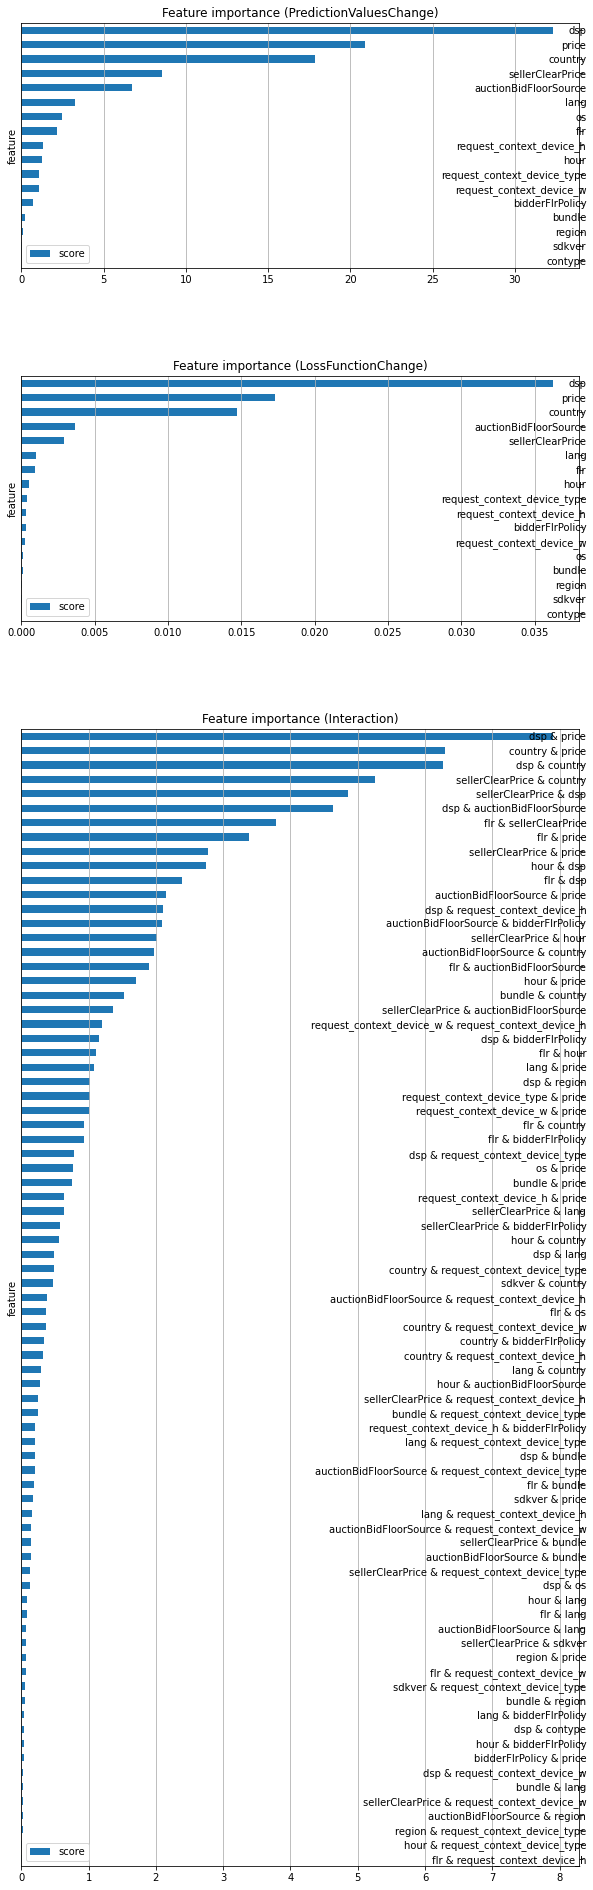

In [7]:
exp_tag = 'baseline_without_const_feats_ifa_sampling_fill_na_ifas'

train_dir = Path(f'./model_logs/{exp_tag}')
train_dir.mkdir(parents=True, exist_ok=True)

# I have removed features with one and only unique feature value across train and test data
features_to_skip = [
    'ssp', 'sdk', 'adt', 'dc',
    TARGET_COL, UNIQ_COL,
]

feature_cols = [x for x in train.columns if x not in features_to_skip]

cat_cols = [
 #'ssp', The one and only value
 'dsp',
 'auctionBidFloorSource',
 #'sdk', The one and only value
 'sdkver',
 'bundle',
 'os',
 'lang',
 'country',
 'region',
 'bidderFlrPolicy',
 #'adt', The one and only value
 #'dc', The one and only value
 'contype',
 'request_context_device_type',
]

# Fill na values of ifa with fake_values
train = add_uniq_index_for_missing_values(train, 'ifa')

# We use only train data for the next experimentations
inputs = ModelInputs(data=train, features_cols=feature_cols, cat_features=cat_cols)

# Split Train dataset randomly for model evaluation (70% goes to train 30% goes to validation);
# We sample data by IFA; One unique value goes only to one sample type (train/test)
params =  {
    "train_test_ratio": 0.70,
    "seed": 1,
    "uniq_col": "ifa"
}

splitter = RandomSplitter(params=params)
inputs.make_test_train(splitter)

# Create CatBoost model classifier
params = {
    "train_dir": str(train_dir),
    "loss_function": "Logloss",
    "iterations": 200,
    "custom_metric": [
      "F1:hints=skip_train~false", "AUC:hints=skip_train~false", 
    ],
    "random_seed": 0,
    "metric_period": 15,
    "depth": 4,
    "task_type": "GPU",
    "devices": "1",
    "learning_rate": 0.05
}

model = CatModel(params)

# Fit model
model.fit(inputs)
# Plot importances on validation set
model.plot_feature_importance(inputs)

# Print training progress (train and validation sample metrics)
display(parse_train_report(exp_tag))

# Compute validation metrics on Train data and Submission (Test dataset)
na_value = -99999
model.evaluate_model(train.fillna(na_value), test.fillna(na_value))

# Results of Iter #3
- Train / Valid Gap looks better, but still we have a GAP on Train / Test.
- Baseline on the test data is F1 score: 0.503 ; ROC AUC: 0.667 (optional)
- Current scores on the test data is F1 score: 0.589 ; ROC AUC: 0.790

## Lets try to drop dsp from feature list

[2024-09-30 23:19:59][INFO] Train data shape is (6754728, 16)
[2024-09-30 23:20:04][INFO] Test data shape is (2886007, 16)
[2024-09-30 23:20:17][WARNING]  Test uniq targets: 2; Train uniq targets: 2;


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6152153	test: 0.6152578	best: 0.6152578 (0)	total: 390ms	remaining: 1m 17s
15:	learn: 0.2388905	test: 0.2390219	best: 0.2390219 (15)	total: 6.37s	remaining: 1m 13s
30:	learn: 0.1960627	test: 0.1964624	best: 0.1964624 (30)	total: 12.9s	remaining: 1m 10s
45:	learn: 0.1822922	test: 0.1828769	best: 0.1828769 (45)	total: 19.7s	remaining: 1m 5s
60:	learn: 0.1756680	test: 0.1763482	best: 0.1763482 (60)	total: 26.2s	remaining: 59.7s
75:	learn: 0.1720388	test: 0.1727488	best: 0.1727488 (75)	total: 32.8s	remaining: 53.5s
90:	learn: 0.1699351	test: 0.1706522	best: 0.1706522 (90)	total: 39.3s	remaining: 47.1s
105:	learn: 0.1678101	test: 0.1685274	best: 0.1685274 (105)	total: 45.5s	remaining: 40.4s
120:	learn: 0.1661352	test: 0.1668581	best: 0.1668581 (120)	total: 51.9s	remaining: 33.9s
135:	learn: 0.1650583	test: 0.1657854	best: 0.1657854 (135)	total: 58.1s	remaining: 27.4s
150:	learn: 0.1642036	test: 0.1649155	best: 0.1649155 (150)	total: 1m 4s	remaining: 20.8s
165:	learn: 0.1634354	t

,iteration,Train_Logloss,Test_Logloss,Train_F1,Test_F1,Train_AUC,Test_AUC
0,0,0.615215,0.615258,0.000000,0.000000,0.861465,0.860609
1,15,0.238891,0.239022,0.284238,0.282021,0.901320,0.900210
2,30,0.196063,0.196462,0.285593,0.282407,0.910657,0.909705
3,45,0.182292,0.182877,0.345449,0.341887,0.915399,0.914422
4,60,0.175668,0.176348,0.392156,0.387674,0.918823,0.917816
5,75,0.172039,0.172749,0.430764,0.425082,0.921192,0.920234
6,90,0.169935,0.170652,0.445058,0.439306,0.923128,0.922201
7,105,0.167810,0.168527,0.462853,0.457650,0.924904,0.924013
8,120,0.166135,0.166858,0.474078,0.468982,0.926340,0.925448
9,135,0.165058,0.165785,0.484781,0.479586,0.927292,0.926421


[2024-09-30 23:23:30][INFO] F1:  Train: 0.5001303953070568; Test: 0.5368529883765052
[2024-09-30 23:23:30][INFO] AUC: Train: 0.8260826674078997; Test: 0.7970155561759115


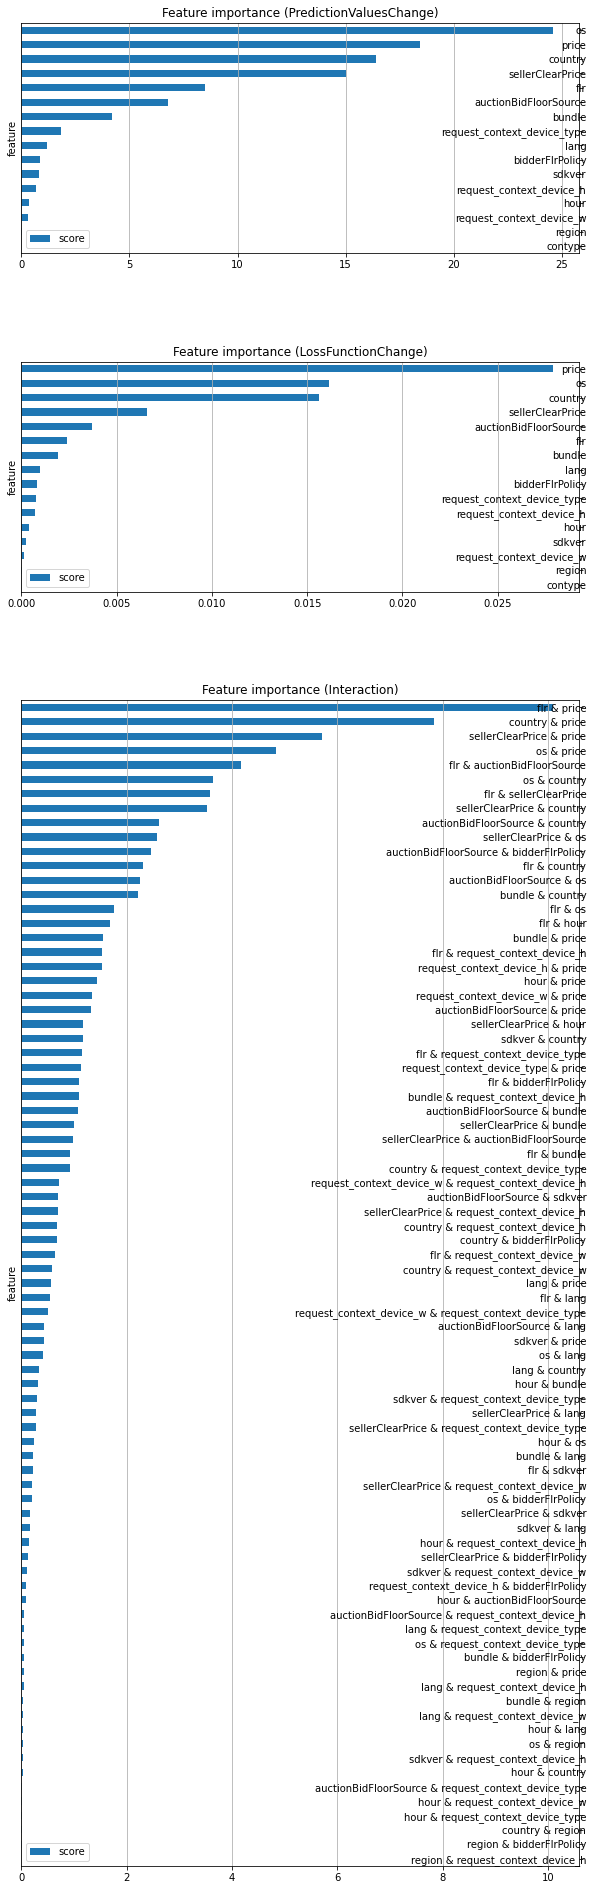

In [8]:
exp_tag = 'baseline_without_const_feats_ifa_sampling_fill_na_ifas_no_dsp_feature'

train_dir = Path(f'./model_logs/{exp_tag}')
train_dir.mkdir(parents=True, exist_ok=True)

# I have removed features with one and only unique feature value across train and test data
features_to_skip = [
    'ssp', 'sdk', 'adt', 'dc', 'dsp',
    TARGET_COL, UNIQ_COL,
]

feature_cols = [x for x in train.columns if x not in features_to_skip]

cat_cols = [
 #'ssp', The one and only value
 #'dsp',
 'auctionBidFloorSource',
 #'sdk', The one and only value
 'sdkver',
 'bundle',
 'os',
 'lang',
 'country',
 'region',
 'bidderFlrPolicy',
 #'adt', The one and only value
 #'dc', The one and only value
 'contype',
 'request_context_device_type',
]

# We use only train data for the next experimentations
inputs = ModelInputs(data=train, features_cols=feature_cols, cat_features=cat_cols)

# Split Train dataset randomly for model evaluation (70% goes to train 30% goes to validation);
# We sample data by IFA; One unique value goes only to one sample type (train/test)
params =  {
    "train_test_ratio": 0.70,
    "seed": 1,
    "uniq_col": "ifa"
}

splitter = RandomSplitter(params=params)
inputs.make_test_train(splitter)

# Create CatBoost model classifier
params = {
    "train_dir": str(train_dir),
    "loss_function": "Logloss",
    "iterations": 200,
    "custom_metric": [
      "F1:hints=skip_train~false", "AUC:hints=skip_train~false", 
    ],
    "random_seed": 0,
    "metric_period": 15,
    "depth": 4,
    "task_type": "GPU",
    "devices": "1",
    "learning_rate": 0.05
}

model = CatModel(params)

# Fit model
model.fit(inputs)
# Plot importances on validation set
model.plot_feature_importance(inputs)

# Print training progress (train and validation sample metrics)
display(parse_train_report(exp_tag))

# Compute validation metrics on Train data and Submission (Test dataset)
na_value = -99999
model.evaluate_model(train.fillna(na_value), test.fillna(na_value))

# Results of iter #4
- We can ignore dsp feature. Quality drop is not so cruisal

# Extra
- The problem here that we have shared user ids between train and test. Lets drop ids of test from the train

In [10]:
len(set(test.ifa) & set(train.ifa))

220431

[2024-09-30 23:28:30][INFO] Train data shape is (5001896, 17)
[2024-09-30 23:28:35][INFO] Test data shape is (2146323, 17)
[2024-09-30 23:28:46][WARNING]  Test uniq targets: 2; Train uniq targets: 2;


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6056480	test: 0.6057038	best: 0.6057038 (0)	total: 317ms	remaining: 1m 3s
15:	learn: 0.1794354	test: 0.1797222	best: 0.1797222 (15)	total: 5.07s	remaining: 58.3s
30:	learn: 0.1337142	test: 0.1340749	best: 0.1340749 (30)	total: 10.4s	remaining: 56.7s
45:	learn: 0.1227897	test: 0.1231075	best: 0.1231075 (45)	total: 15.7s	remaining: 52.5s
60:	learn: 0.1183686	test: 0.1186567	best: 0.1186567 (60)	total: 20.9s	remaining: 47.7s
75:	learn: 0.1159774	test: 0.1162485	best: 0.1162485 (75)	total: 26.2s	remaining: 42.7s
90:	learn: 0.1146672	test: 0.1149168	best: 0.1149168 (90)	total: 31.3s	remaining: 37.5s
105:	learn: 0.1136559	test: 0.1138963	best: 0.1138963 (105)	total: 36.3s	remaining: 32.2s
120:	learn: 0.1128897	test: 0.1131204	best: 0.1131204 (120)	total: 41.5s	remaining: 27.1s
135:	learn: 0.1122702	test: 0.1124955	best: 0.1124955 (135)	total: 46.6s	remaining: 21.9s
150:	learn: 0.1117207	test: 0.1119388	best: 0.1119388 (150)	total: 51.8s	remaining: 16.8s
165:	learn: 0.1112799	test

,iteration,Train_Logloss,Test_Logloss,Train_F1,Test_F1,Train_AUC,Test_AUC
0,0,0.605648,0.605704,0.000000,0.000000,0.849798,0.850754
1,15,0.179435,0.179722,0.242801,0.244510,0.899155,0.899650
2,30,0.133714,0.134075,0.261952,0.262453,0.916578,0.917001
3,45,0.122790,0.123107,0.355645,0.356345,0.921617,0.922070
4,60,0.118369,0.118657,0.410316,0.408468,0.924502,0.924930
5,75,0.115977,0.116248,0.421553,0.420288,0.927003,0.927397
6,90,0.114667,0.114917,0.429444,0.428209,0.928351,0.928755
7,105,0.113656,0.113896,0.438900,0.437475,0.929574,0.929994
8,120,0.112890,0.113120,0.443084,0.442027,0.930512,0.930947
9,135,0.112270,0.112496,0.448422,0.447455,0.931370,0.931811


[2024-09-30 23:31:24][INFO] F1:  Train: 0.45779217643115594; Test: 0.574471333937616
[2024-09-30 23:31:24][INFO] AUC: Train: 0.8290160217672975; Test: 0.7923047299590541


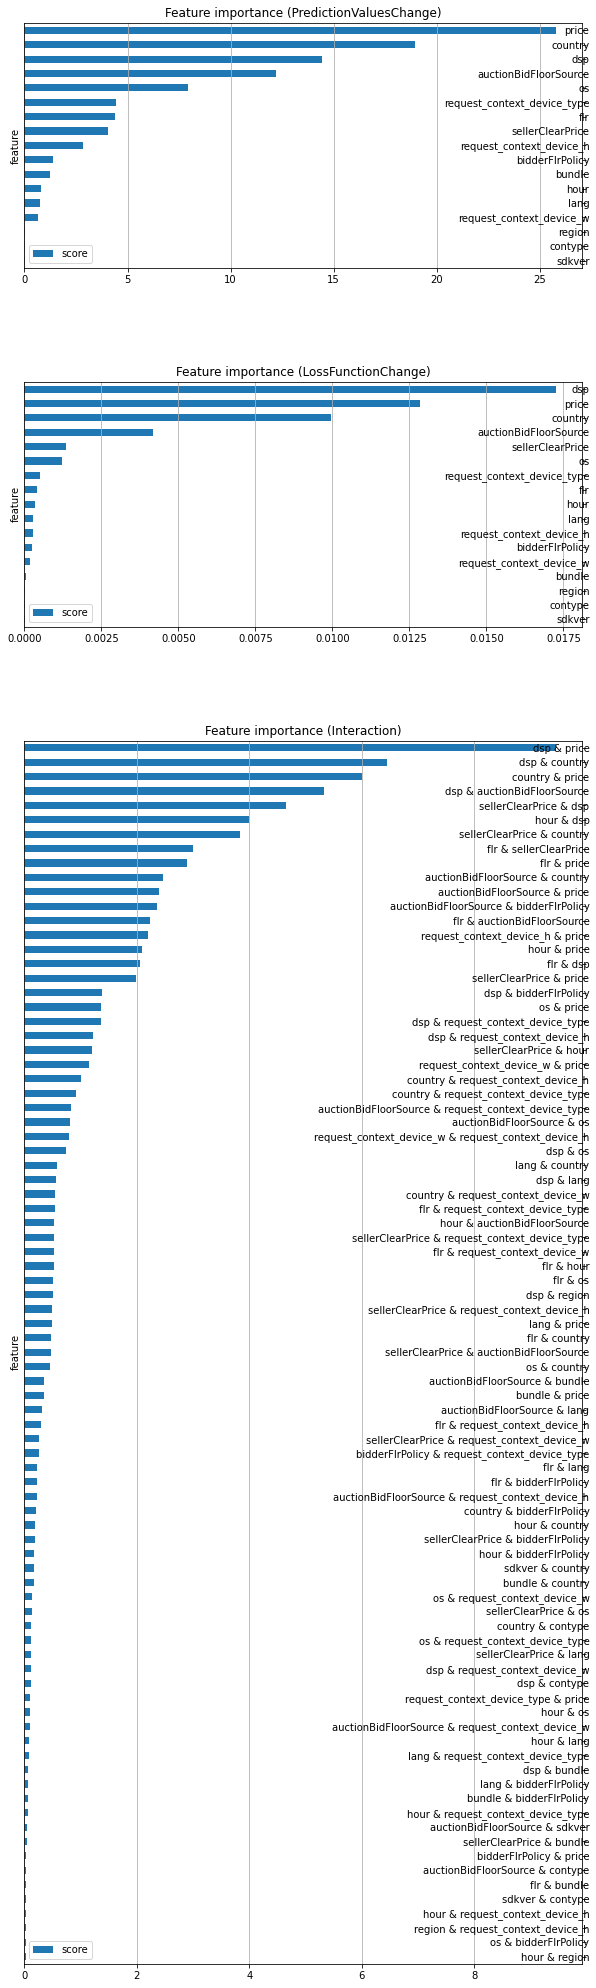

In [11]:
exp_tag = 'baseline_without_const_feats_ifa_sampling_fill_na_ifas_no_test_ifas'

train_dir = Path(f'./model_logs/{exp_tag}')
train_dir.mkdir(parents=True, exist_ok=True)

# I have removed features with one and only unique feature value across train and test data
features_to_skip = [
    'ssp', 'sdk', 'adt', 'dc',
    TARGET_COL, UNIQ_COL,
]

feature_cols = [x for x in train.columns if x not in features_to_skip]

cat_cols = [
 #'ssp', The one and only value
 'dsp',
 'auctionBidFloorSource',
 #'sdk', The one and only value
 'sdkver',
 'bundle',
 'os',
 'lang',
 'country',
 'region',
 'bidderFlrPolicy',
 #'adt', The one and only value
 #'dc', The one and only value
 'contype',
 'request_context_device_type',
]

# Lets drom all ifa ids of test (submission) from the train
train_idx = ~train.ifa.isin(set(test.ifa))
train = train.loc[train_idx, :].reset_index(drop=True)

# We use only train data for the next experimentations
inputs = ModelInputs(data=train, features_cols=feature_cols, cat_features=cat_cols)

# Split Train dataset randomly for model evaluation (70% goes to train 30% goes to validation);
# We sample data by IFA; One unique value goes only to one sample type (train/test)
params =  {
    "train_test_ratio": 0.70,
    "seed": 1,
    "uniq_col": "ifa"
}

splitter = RandomSplitter(params=params)
inputs.make_test_train(splitter)

# Create CatBoost model classifier
params = {
    "train_dir": str(train_dir),
    "loss_function": "Logloss",
    "iterations": 200,
    "custom_metric": [
      "F1:hints=skip_train~false", "AUC:hints=skip_train~false", 
    ],
    "random_seed": 0,
    "metric_period": 15,
    "depth": 4,
    "task_type": "GPU",
    "devices": "1",
    "learning_rate": 0.05
}

model = CatModel(params)

# Fit model
model.fit(inputs)
# Plot importances on validation set
model.plot_feature_importance(inputs)

# Print training progress (train and validation sample metrics)
display(parse_train_report(exp_tag))

# Compute validation metrics on Train data and Submission (Test dataset)
na_value = -99999
model.evaluate_model(train.fillna(na_value), test.fillna(na_value))

# Results of Iter #4
- Train / Test gap looks not so good.
- It is unreal to use this approach in the real life (we don't know user ids from test at the training step)
- But this is not a good sign. Maybe, we have a leakage.


# Summary
- The final submission is in iteration #3